In [17]:
# Celda 1: configuración e imports principales

%run ./00_template.py

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

print("Notebook 02 – Exploración de oferta de servicios")
print(f"Geodatabase utilizada: {RUTA_GPKG}")


=== Template PEP1 Desiertos cargado ===
BASE_DIR        : /home/jovyan
CARGA_DIR       : /home/jovyan/data/raw/Carga de datos
RUTA_GPKG       : /home/jovyan/data/raw/Carga de datos/geodatabase_proyecto.gpkg
RUTA_CENSO_CSV  : /home/jovyan/data/raw/Carga de datos/censo_RM_totales_comuna.csv
Notebook 02 – Exploración de oferta de servicios
Geodatabase utilizada: /home/jovyan/data/raw/Carga de datos/geodatabase_proyecto.gpkg


In [18]:
# Celda 2 — Definición de capas de interés y carga de comunas con columnas reales

LAYER_COMUNAS = "comunas_rm_censo"

# Diccionario de capas de servicios disponibles en tu GeoPackage
SERVICE_LAYERS = {
    "salud": "establecimientos_salud",
    "educacion_escolar": "establecimientos_educacion",
    "educacion_superior": "establecimientos_educacion_superior",
    "supermercados": "osm_supermercados",
    "almacenes_barrio": "osm_almacenes_barrio",
    "bancos": "osm_bancos",
    "ferias_libres": "ferias_libres",
    "areas_verdes": "areas_verdes",
    "cuarteles_carabineros": "cuarteles_carabineros",
    "companias_bomberos": "companias_bomberos",
    "estadios": "osm_estadios",
    "malls": "osm_malls",
    "bencineras": "osm_bencineras",
    "iglesias": "osm_iglesias",
    "museos": "osm_museos",
    "infraestructura_deportiva": "infraestructura_deportiva",
    "paradas_micro": "paradas_micro",
    "paradas_metro_tren": "paradas_metro_tren",
}

# Cargar la capa de comunas desde el GeoPackage
comunas = gpd.read_file(RUTA_GPKG, layer=LAYER_COMUNAS)

print("Columnas disponibles en comunas_rm_censo:")
print(comunas.columns)


Columnas disponibles en comunas_rm_censo:
Index(['CUT_REG', 'CUT_PROV', 'CUT_COM', 'REGION', 'PROVINCIA', 'COMUNA',
       'SUPERFICIE', 'Código comuna', 'Población censada', 'Hombres',
       'Mujeres', 'geometry'],
      dtype='object')


In [19]:
# Celda 3: función para calcular conteos de servicios por comuna (versión robusta)

def contar_servicios_por_comuna(
    layer_name: str,
    comunas_gdf: gpd.GeoDataFrame,
    id_col: str = "CUT_COM",
) -> pd.DataFrame:
    """
    Calcula el número de registros de una capa de servicios dentro de cada comuna.
    
    Parámetros
    ----------
    layer_name : str
        Nombre de la capa en el GeoPackage (por ejemplo 'establecimientos_salud').
    comunas_gdf : GeoDataFrame
        GeoDataFrame de comunas (capa comunas_rm_censo).
    id_col : str
        Nombre de la columna identificadora de comuna (ej. 'CUT_COM').
    
    Retorna
    -------
    DataFrame con columnas [id_col, 'conteo_<layer_name>'].
    """
    # 1. Cargar servicios desde el GeoPackage y llevar al mismo CRS
    servicios = gpd.read_file(RUTA_GPKG, layer=layer_name)
    servicios = servicios.to_crs(comunas_gdf.crs)

    # 2. Limpiar posibles columnas heredadas de otros joins
    servicios = servicios.copy()
    comunas_simple = comunas_gdf[[id_col, "geometry"]].copy()

    for col in ["index_left", "index_right"]:
        if col in servicios.columns:
            servicios = servicios.drop(columns=[col])
        if col in comunas_simple.columns:
            comunas_simple = comunas_simple.drop(columns=[col])

    servicios = servicios.reset_index(drop=True)
    comunas_simple = comunas_simple.reset_index(drop=True)

    # 3. Cruce espacial punto-en-polígono
    join = gpd.sjoin(
        servicios,
        comunas_simple,
        how="inner",
        predicate="within",
    )

    # 4. Determinar cómo quedó llamada la columna de comuna en el join
    posibles_cols = [id_col, f"{id_col}_right", f"{id_col}_left"]
    comuna_col = None
    for col in posibles_cols:
        if col in join.columns:
            comuna_col = col
            break

    if comuna_col is None:
        raise KeyError(
            f"No se encontró la columna de comuna ({posibles_cols}) en el resultado del sjoin "
            f"para la capa {layer_name}. Columnas disponibles: {join.columns.tolist()}"
        )

    # 5. Agrupar por comuna y contar
    serie_conteo = join.groupby(comuna_col).size()

    df_conteo = serie_conteo.reset_index(name=f"conteo_{layer_name}")

    # 6. Normalizar el nombre de la columna de comuna a id_col
    if comuna_col != id_col:
        df_conteo = df_conteo.rename(columns={comuna_col: id_col})

    return df_conteo



In [20]:
# Celda 4: construcción de tabla de indicadores por comuna

# Nombre de la columna de población en tu capa de comunas
COL_POBLACION = "Población censada"

indicadores = comunas[["CUT_COM", "COMUNA", COL_POBLACION]].copy()
indicadores = indicadores.rename(
    columns={
        "CUT_COM": "cod_comuna",
        "COMUNA": "comuna",
        COL_POBLACION: "poblacion",
    }
)

# Lista de servicios para los que se calcularán tasas
servicios_clave = [
    "establecimientos_salud",
    "establecimientos_educacion",
    "establecimientos_educacion_superior",
    "osm_supermercados",
    "osm_almacenes_barrio",
    "osm_bancos",
    "ferias_libres",
    "areas_verdes",
    "paradas_micro",
    "paradas_metro_tren",
]

# Conteos por comuna
for layer in servicios_clave:
    df_conteo = contar_servicios_por_comuna(layer, comunas, id_col="CUT_COM")
    df_conteo = df_conteo.rename(columns={"CUT_COM": "cod_comuna"})
    indicadores = indicadores.merge(df_conteo, on="cod_comuna", how="left")

# Reemplazar NaN por cero en conteos
conteo_cols = [c for c in indicadores.columns if c.startswith("conteo_")]
indicadores[conteo_cols] = indicadores[conteo_cols].fillna(0).astype(int)

# Tasas por 10 000 habitantes
for c in conteo_cols:
    nombre_servicio = c.replace("conteo_", "")
    indicadores[f"tasa_{nombre_servicio}_x10k"] = (
        indicadores[c] / indicadores["poblacion"] * 10000
    )

indicadores.sort_values("comuna", inplace=True)
indicadores.head()



,cod_comuna,comuna,poblacion,conteo_establecimientos_salud,conteo_establecimientos_educacion,conteo_establecimientos_educacion_superior,conteo_osm_supermercados,conteo_osm_almacenes_barrio,conteo_osm_bancos,conteo_ferias_libres,...,tasa_establecimientos_salud_x10k,tasa_establecimientos_educacion_x10k,tasa_establecimientos_educacion_superior_x10k,tasa_osm_supermercados_x10k,tasa_osm_almacenes_barrio_x10k,tasa_osm_bancos_x10k,tasa_ferias_libres_x10k,tasa_areas_verdes_x10k,tasa_paradas_micro_x10k,tasa_paradas_metro_tren_x10k
40,13502,Alhué,7768,6,5,0,0,0,0,0,...,7.723996,6.436663,0.000000,0.000000,0.000000,0.000000,0.000000,1.287333,0.000000,0.000000
18,13402,Buin,116969,21,49,3,0,0,0,3,...,1.795347,4.189144,0.256478,0.000000,0.000000,0.000000,0.256478,12.567432,0.000000,0.256478
14,13403,Calera de Tango,25491,4,14,0,5,6,2,4,...,1.569181,5.492134,0.000000,1.961477,2.353772,0.784591,1.569181,10.591974,0.784591,0.000000
8,13102,Cerrillos,85041,10,33,2,8,24,10,6,...,1.175903,3.880481,0.235181,0.940723,2.822168,1.175903,0.705542,24.458790,32.925295,0.000000
42,13103,Cerro Navia,127250,10,49,0,2,36,2,10,...,0.785855,3.850688,0.000000,0.157171,2.829077,0.157171,0.785855,17.681729,20.510806,0.000000


/tmp/ipykernel_555/888042837.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", n_comunas)


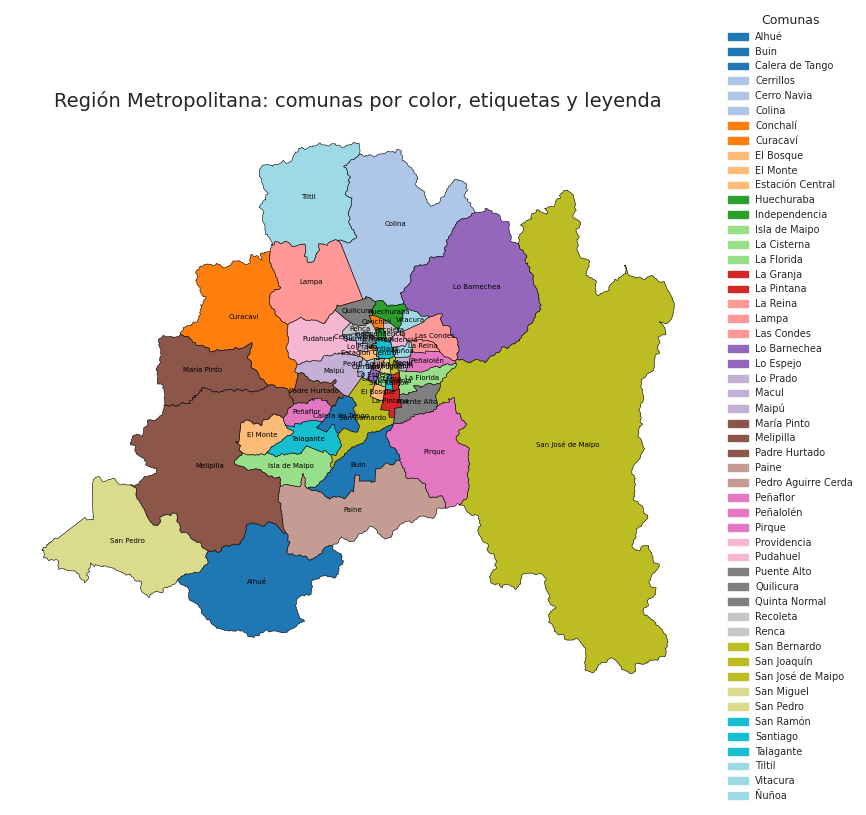

💾 Figura guardada en: /home/jovyan/outputs/figures/area_estudio/mapa_rm_comunas_etiquetas_y_leyenda.png


In [26]:
# Celda 4-d: Mapa RM con comunas en distintos colores,
# etiquetas dentro de cada comuna y listado (leyenda) a la derecha.

import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors

# 1. Lista de comunas y colormap
comunas_unicas = sorted(comunas["COMUNA"].unique())
n_comunas = len(comunas_unicas)
cmap = cm.get_cmap("tab20", n_comunas)

fig, ax = plt.subplots(figsize=(12, 8))

# 2. Pintar cada comuna con su color
for i, nombre in enumerate(comunas_unicas):
    color = cmap(i)
    comunas[comunas["COMUNA"] == nombre].plot(
        ax=ax,
        color=color,
        edgecolor="black",
        linewidth=0.4,
    )

# 3. Agregar etiquetas (nombres) en el centro de cada comuna
#    Usamos el centroide de la geometría
for i, row in comunas.iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x,
        centroid.y,
        row["COMUNA"],
        fontsize=5,      # si se ve muy chico, prueba 6; si se sobrepone mucho, baja a 4
        ha="center",
        va="center",
        color="black"
    )

ax.set_title("Región Metropolitana: comunas por color, etiquetas y leyenda", fontsize=14)
ax.set_axis_off()

# 4. Crear listado (leyenda) de color + nombre de comuna
handles = []
for i, nombre in enumerate(comunas_unicas):
    color = cmap(i)
    patch = mpatches.Patch(color=color, label=nombre)
    handles.append(patch)

# 5. Ubicar la leyenda a la derecha
leg = ax.legend(
    handles=handles,
    title="Comunas",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    fontsize=7,
    title_fontsize=9,
    frameon=False
)

plt.tight_layout()
plt.show()

# 6. Guardar figura para el PPT
save_figure(fig, "mapa_rm_comunas_etiquetas_y_leyenda", subdir="area_estudio")




/tmp/ipykernel_555/1725249265.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("tab20", n_comunas)


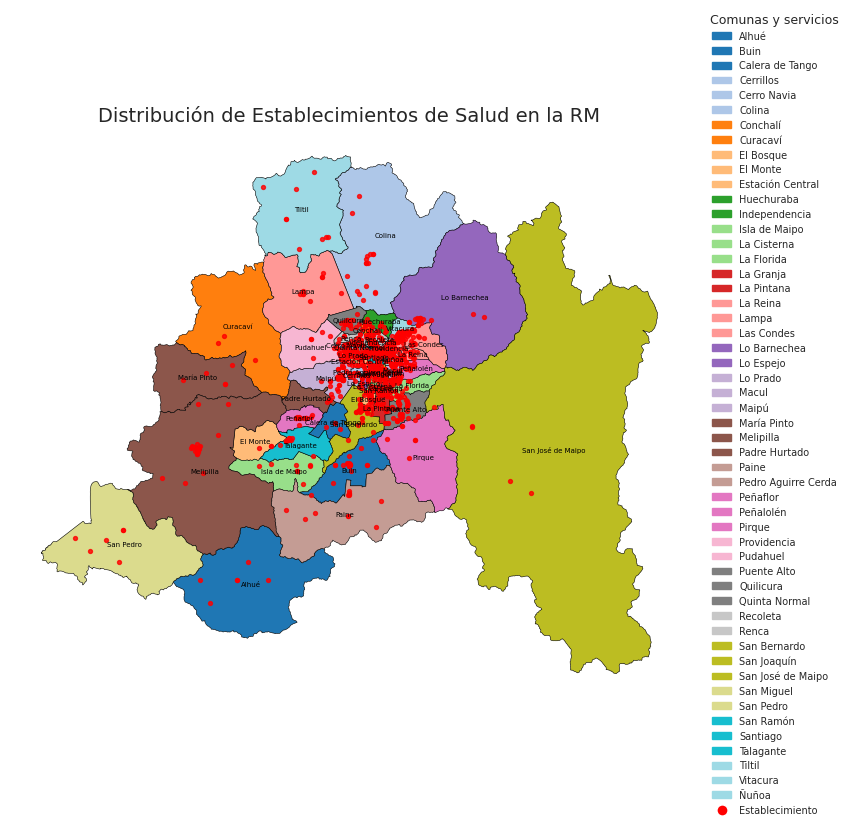

💾 Figura guardada en: /home/jovyan/outputs/figures/caracteristicas_relevantes/mapa_rm_salud_comunas_colores.png


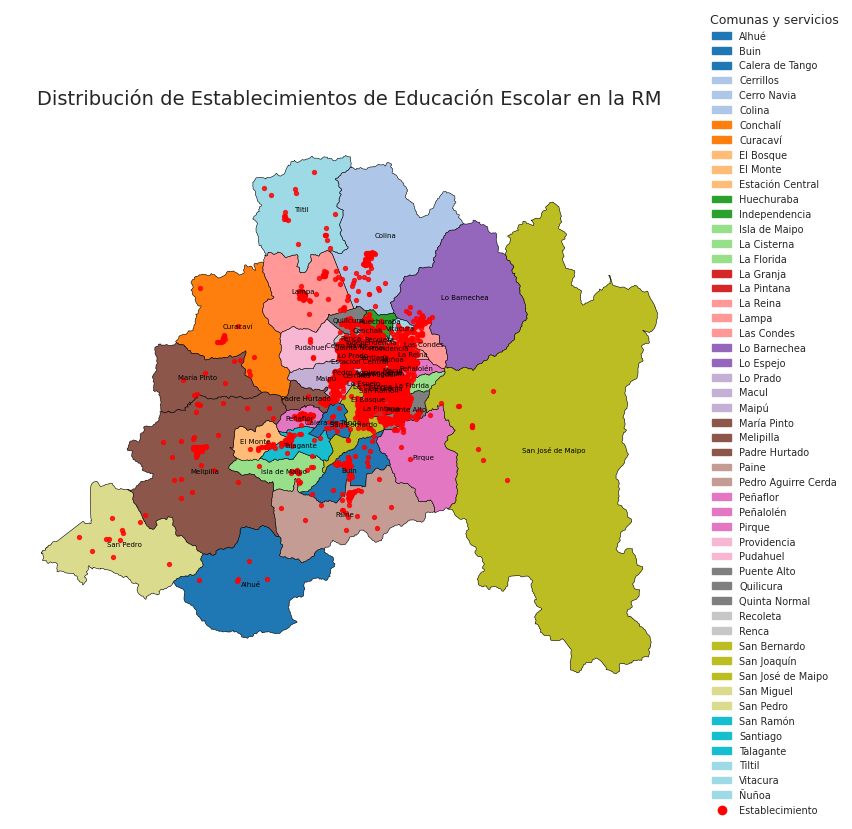

💾 Figura guardada en: /home/jovyan/outputs/figures/caracteristicas_relevantes/mapa_rm_educacion_comunas_colores.png


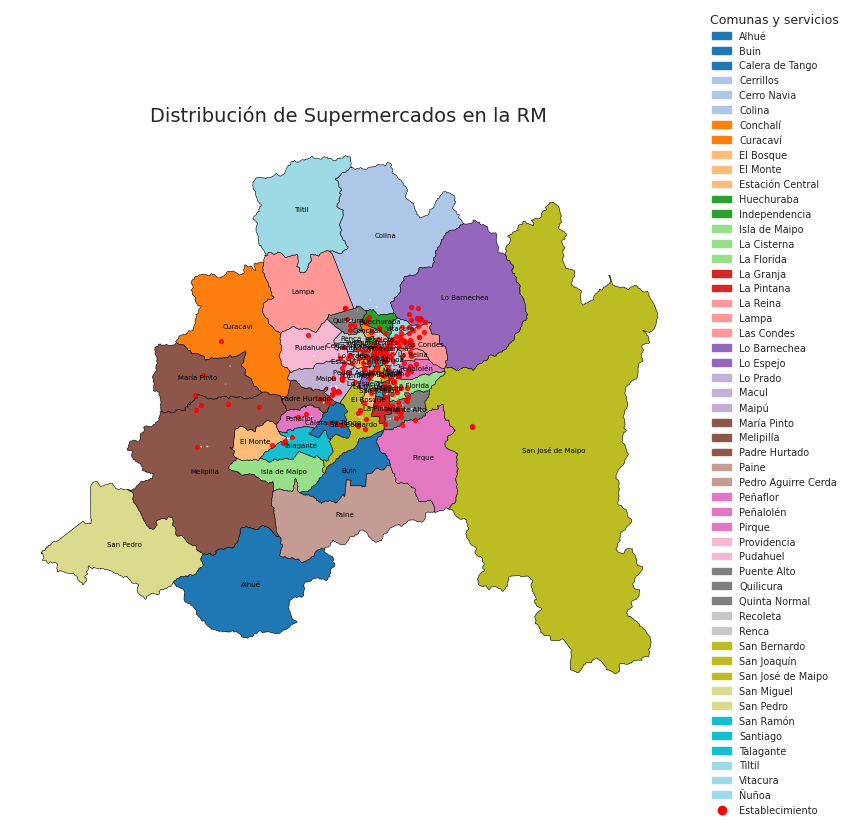

💾 Figura guardada en: /home/jovyan/outputs/figures/caracteristicas_relevantes/mapa_rm_supermercados_comunas_colores.png


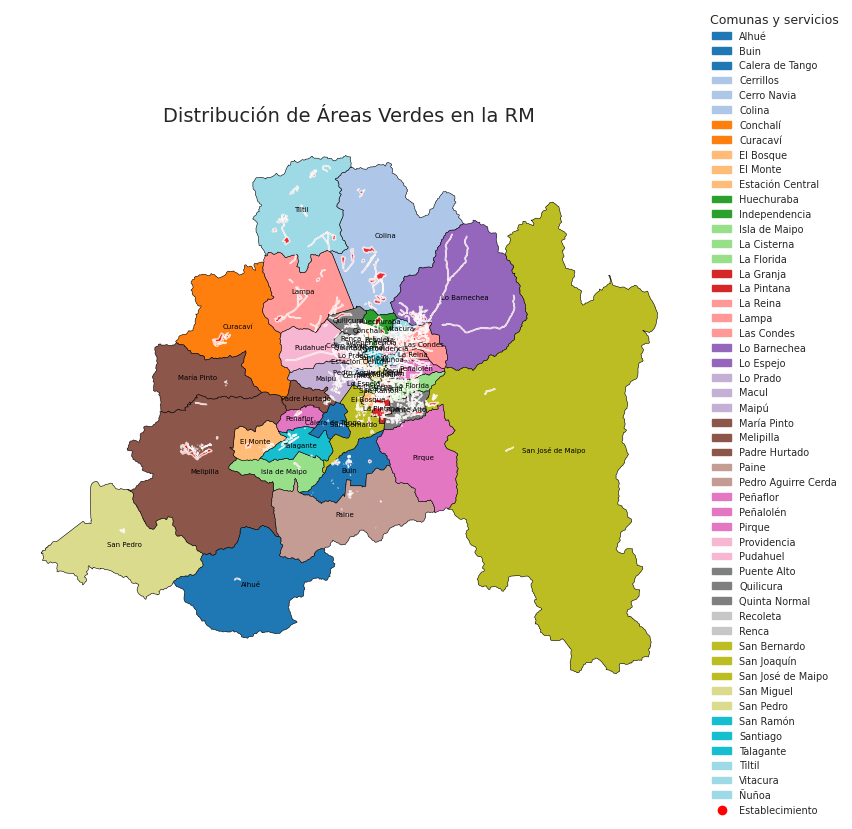

💾 Figura guardada en: /home/jovyan/outputs/figures/caracteristicas_relevantes/mapa_rm_areas_verdes_comunas_colores.png


In [28]:
# Celda 4-f: Mapas de servicios con comunas en colores,
# etiquetas dentro, y leyenda a la derecha.
#
# Servicios: salud, educación escolar, supermercados y áreas verdes.

import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Lista de comunas y colormap (mismos colores para todos los mapas)
comunas_unicas = sorted(comunas["COMUNA"].unique())
n_comunas = len(comunas_unicas)
cmap = cm.get_cmap("tab20", n_comunas)


def plot_servicio_coloreado(layer_name, title, filename):
    """
    Dibuja:
    - Comunas en colores distintivos + etiquetas + leyenda de comunas
    - Puntos del servicio indicado por 'layer_name'
    y guarda la figura como PNG.
    """

    # Cargar capa de servicio y llevar al mismo CRS que comunas
    gdf_serv = gpd.read_file(RUTA_GPKG, layer=layer_name).to_crs(comunas.crs)

    fig, ax = plt.subplots(figsize=(12, 8))

    # 2. Pintar cada comuna con su color
    for i, nombre in enumerate(comunas_unicas):
        color = cmap(i)
        comunas[comunas["COMUNA"] == nombre].plot(
            ax=ax,
            color=color,
            edgecolor="black",
            linewidth=0.4,
        )

    # 3. Etiquetas con el nombre de la comuna en su centroide
    for i, row in comunas.iterrows():
        centroid = row.geometry.centroid
        ax.text(
            centroid.x,
            centroid.y,
            row["COMUNA"],
            fontsize=5,
            ha="center",
            va="center",
            color="black"
        )

    # 4. Dibujar puntos del servicio (en rojo)
    if not gdf_serv.empty:
        gdf_serv.plot(
            ax=ax,
            color="red",
            markersize=8,
            alpha=0.8
        )

    ax.set_title(title, fontsize=14)
    ax.set_axis_off()

    # 5. Leyenda de comunas (color + nombre)
    handles_comunas = []
    for i, nombre in enumerate(comunas_unicas):
        color = cmap(i)
        patch = mpatches.Patch(color=color, label=nombre)
        handles_comunas.append(patch)

    # 6. Leyenda para el servicio (puntos rojos)
    servicio_handle = Line2D(
        [0], [0],
        marker='o',
        color='w',
        label='Establecimiento',
        markerfacecolor='red',
        markersize=8
    )

    # Unimos ambas cosas en la misma leyenda
    handles = handles_comunas + [servicio_handle]

    leg = ax.legend(
        handles=handles,
        title="Comunas y servicios",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        fontsize=7,
        title_fontsize=9,
        frameon=False
    )

    plt.tight_layout()
    plt.show()

    # 7. Guardar figura para el PPT
    save_figure(fig, filename, subdir="caracteristicas_relevantes")


# ===============================
# 1. Distribución de establecimientos de salud
# ===============================
plot_servicio_coloreado(
    layer_name="establecimientos_salud",
    title="Distribución de Establecimientos de Salud en la RM",
    filename="mapa_rm_salud_comunas_colores"
)

# ===============================
# 2. Distribución de establecimientos de educación escolar
# ===============================
plot_servicio_coloreado(
    layer_name="establecimientos_educacion",
    title="Distribución de Establecimientos de Educación Escolar en la RM",
    filename="mapa_rm_educacion_comunas_colores"
)

# ===============================
# 3. Distribución de supermercados
# ===============================
plot_servicio_coloreado(
    layer_name="osm_supermercados",
    title="Distribución de Supermercados en la RM",
    filename="mapa_rm_supermercados_comunas_colores"
)

# ===============================
# 4. Distribución de áreas verdes
# ===============================
plot_servicio_coloreado(
    layer_name="areas_verdes",
    title="Distribución de Áreas Verdes en la RM",
    filename="mapa_rm_areas_verdes_comunas_colores"
)



In [ ]:
# Celda 5: preparación de tabla base para gráficos estadísticos

cols_graficos = [
    "comuna",
    "poblacion",
    "conteo_establecimientos_salud",
    "conteo_establecimientos_educacion",
    "conteo_establecimientos_educacion_superior",
    "conteo_osm_supermercados",
]

# Filtrar solo las columnas que existan (por seguridad)
cols_existentes = [c for c in cols_graficos if c in indicadores.columns]
df_stats = indicadores[cols_existentes].copy()

print("Columnas disponibles para gráficos estadísticos:")
print(df_stats.columns)


💾 Figura guardada en: /home/jovyan/outputs/figures/hist_establecimientos_salud_por_comuna.png


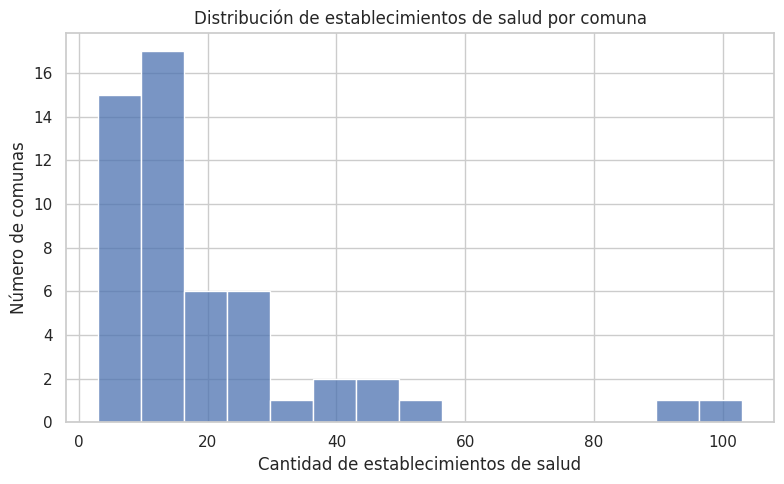

In [6]:
# Celda 6: histograma de establecimientos de salud por comuna

fig, ax = plt.subplots(figsize=(8, 5))

if "conteo_establecimientos_salud" in df_stats.columns:
    sns.histplot(df_stats["conteo_establecimientos_salud"], bins=15, kde=False, ax=ax)
    ax.set_title("Distribución de establecimientos de salud por comuna")
    ax.set_xlabel("Cantidad de establecimientos de salud")
    ax.set_ylabel("Número de comunas")
    plt.tight_layout()
    save_figure(fig, "hist_establecimientos_salud_por_comuna")
else:
    ax.text(0.5, 0.5, "No se encontró la columna conteo_establecimientos_salud",
            ha="center", va="center", transform=ax.transAxes)
plt.show()


💾 Figura guardada en: /home/jovyan/outputs/figures/hist_establecimientos_educacion_por_comuna.png


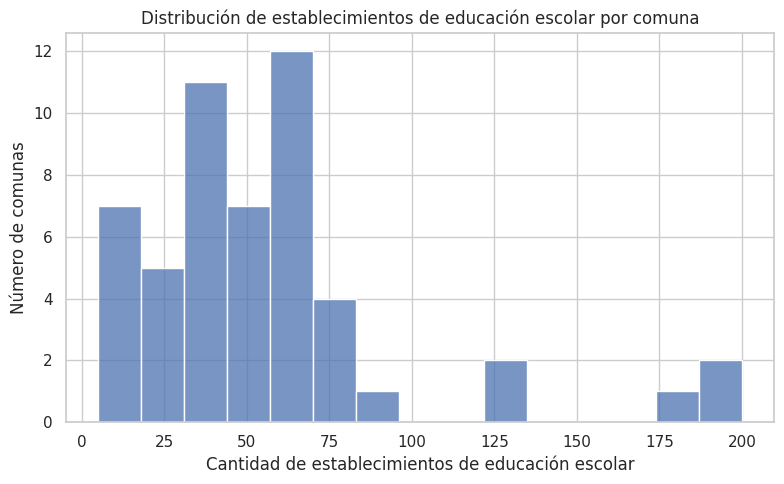

In [8]:
# Celda 7: histograma de establecimientos de educación escolar por comuna

fig, ax = plt.subplots(figsize=(8, 5))

if "conteo_establecimientos_educacion" in df_stats.columns:
    sns.histplot(df_stats["conteo_establecimientos_educacion"], bins=15, kde=False, ax=ax)
    ax.set_title("Distribución de establecimientos de educación escolar por comuna")
    ax.set_xlabel("Cantidad de establecimientos de educación escolar")
    ax.set_ylabel("Número de comunas")
    plt.tight_layout()
    save_figure(fig, "hist_establecimientos_educacion_por_comuna")
else:
    ax.text(0.5, 0.5, "No se encontró la columna conteo_establecimientos_educacion",
            ha="center", va="center", transform=ax.transAxes)
plt.show()


💾 Figura guardada en: /home/jovyan/outputs/figures/bar_comparacion_salud_educacion_supermercados.png


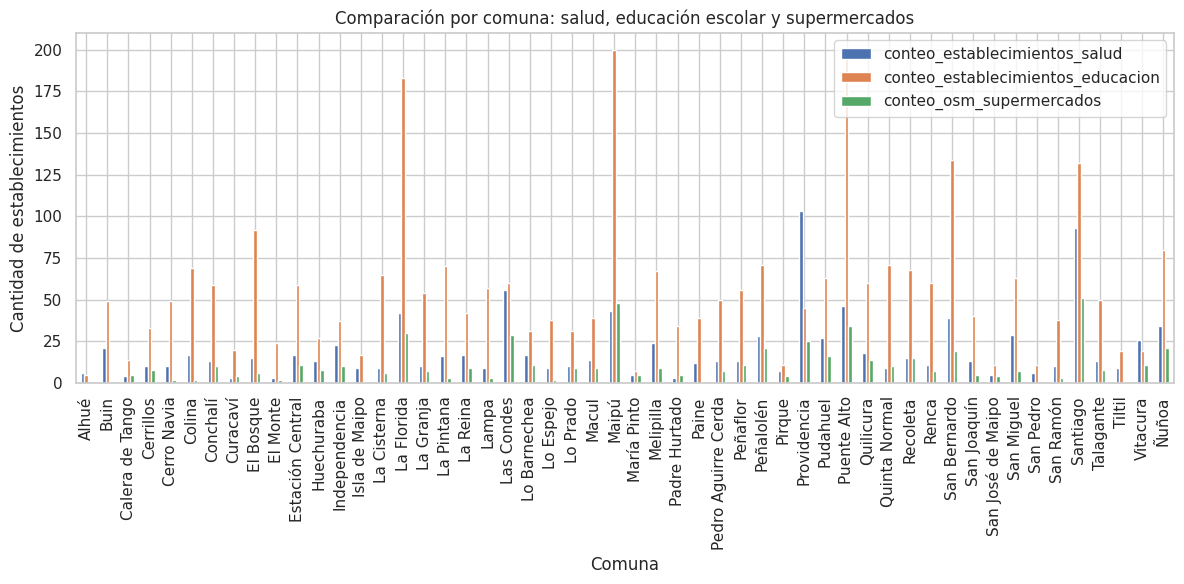

In [9]:
# Celda 8: gráfico de barras comparativo (salud, educación y supermercados)

cols_bar = [
    "conteo_establecimientos_salud",
    "conteo_establecimientos_educacion",
    "conteo_osm_supermercados",
]

cols_bar = [c for c in cols_bar if c in df_stats.columns]

if cols_bar:
    df_bar = df_stats[["comuna"] + cols_bar].set_index("comuna")
    fig, ax = plt.subplots(figsize=(12, 6))
    df_bar.plot(kind="bar", ax=ax)
    ax.set_title("Comparación por comuna: salud, educación escolar y supermercados")
    ax.set_xlabel("Comuna")
    ax.set_ylabel("Cantidad de establecimientos")
    plt.xticks(rotation=90)
    plt.tight_layout()
    save_figure(fig, "bar_comparacion_salud_educacion_supermercados")
    plt.show()
else:
    fig, ax = plt.subplots()
    ax.text(0.5, 0.5, "No hay columnas suficientes para el gráfico comparativo",
            ha="center", va="center", transform=ax.transAxes)
    plt.show()


💾 Figura guardada en: /home/jovyan/outputs/figures/boxplot_establecimientos_educacion.png


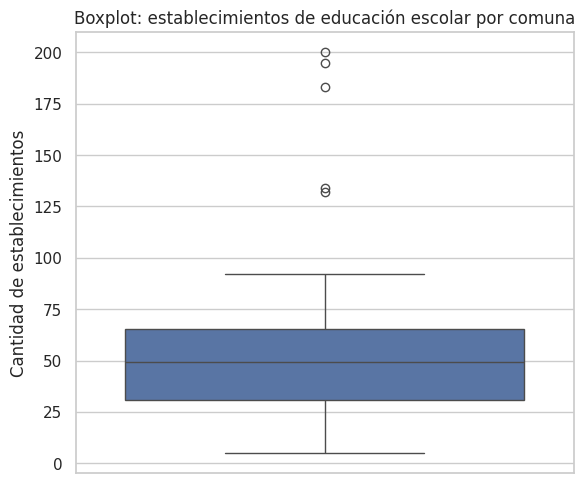

In [10]:
# Celda 9: boxplot de número de establecimientos de educación escolar

fig, ax = plt.subplots(figsize=(6, 5))

if "conteo_establecimientos_educacion" in df_stats.columns:
    sns.boxplot(y=df_stats["conteo_establecimientos_educacion"], ax=ax)
    ax.set_title("Boxplot: establecimientos de educación escolar por comuna")
    ax.set_ylabel("Cantidad de establecimientos")
    plt.tight_layout()
    save_figure(fig, "boxplot_establecimientos_educacion")
else:
    ax.text(0.5, 0.5, "No se encontró la columna conteo_establecimientos_educacion",
            ha="center", va="center", transform=ax.transAxes)
plt.show()


💾 Figura guardada en: /home/jovyan/outputs/figures/heatmap_correlacion_servicios.png


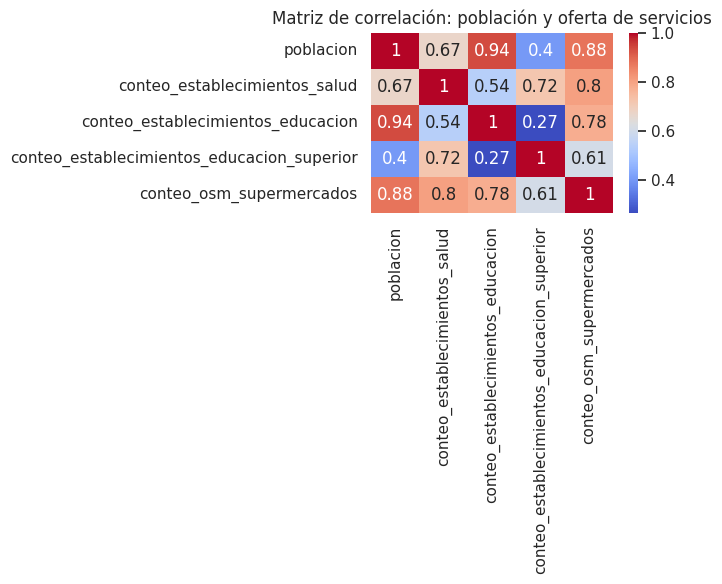

In [11]:
# Celda 10: matriz de correlación entre población y oferta de servicios

# Seleccionar solo columnas numéricas
df_num = df_stats.select_dtypes(include=["int64", "float64"]).copy()

if df_num.shape[1] >= 2:
    corr = df_num.corr()
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax)
    ax.set_title("Matriz de correlación: población y oferta de servicios")
    plt.tight_layout()
    save_figure(fig, "heatmap_correlacion_servicios")
    plt.show()
else:
    fig, ax = plt.subplots()
    ax.text(0.5, 0.5, "No hay suficientes columnas numéricas para calcular correlación",
            ha="center", va="center", transform=ax.transAxes)
    plt.show()


In [8]:
# Celda 11: comunas con menor oferta relativa

columnas_tasa_resumen = [
    "tasa_establecimientos_salud_x10k",
    "tasa_establecimientos_educacion_x10k",
    "tasa_establecimientos_educacion_superior_x10k",
    "tasa_osm_supermercados_x10k",
]

resumen = indicadores[["comuna", "poblacion"] + columnas_tasa_resumen].copy()

# Ejemplo: menores tasas de supermercados
resumen_supermercados_bajo = resumen.sort_values(
    "tasa_osm_supermercados_x10k"
).head(10)

print("Comunas con menor tasa de supermercados por 10.000 habitantes:")
resumen_supermercados_bajo


Comunas con menor tasa de supermercados por 10.000 habitantes:


,comuna,poblacion,tasa_establecimientos_salud_x10k,tasa_establecimientos_educacion_x10k,tasa_establecimientos_educacion_superior_x10k,tasa_osm_supermercados_x10k
40,Alhué,7768,7.723996,6.436663,0.000000,0.000000
18,Buin,116969,1.795347,4.189144,0.256478,0.000000
45,Tiltil,19742,4.558809,9.624152,0.000000,0.000000
28,Paine,78828,1.522302,4.947481,0.000000,0.000000
50,San Pedro,11108,5.401512,9.902773,0.000000,0.000000
6,Isla de Maipo,39274,2.291592,4.328563,0.000000,0.000000
16,Colina,173293,0.980998,3.981696,0.057706,0.115411
42,Cerro Navia,127250,0.785855,3.850688,0.000000,0.157171
24,La Pintana,175421,0.912091,3.990400,0.228023,0.171017
10,Lampa,145160,0.620006,3.926702,0.000000,0.206669


In [9]:
# Celda 12: crear GeoDataFrame con indicadores + geometría

comunas_indicadores = comunas.merge(
    indicadores,
    left_on="CUT_COM",
    right_on="cod_comuna",
    how="left",
)

comunas_indicadores.head()


,CUT_REG,CUT_PROV,CUT_COM,REGION,PROVINCIA,COMUNA,SUPERFICIE,Código comuna,Población censada,Hombres,...,tasa_establecimientos_salud_x10k,tasa_establecimientos_educacion_x10k,tasa_establecimientos_educacion_superior_x10k,tasa_osm_supermercados_x10k,tasa_osm_almacenes_barrio_x10k,tasa_osm_bancos_x10k,tasa_ferias_libres_x10k,tasa_areas_verdes_x10k,tasa_paradas_micro_x10k,tasa_paradas_metro_tren_x10k
0,13,131,13130,Metropolitana de Santiago,Santiago,San Miguel,9.63,13130,150829,71229,...,1.922707,4.176916,0.464102,0.464102,1.458605,1.127104,0.397801,2.983511,14.121953,0.0
1,13,131,13118,Metropolitana de Santiago,Santiago,Macul,12.81,13118,123800,58479,...,1.130856,3.150242,0.565428,0.726979,0.807754,0.646204,0.646204,5.896607,23.586430,0.0
2,13,131,13119,Metropolitana de Santiago,Santiago,Maipú,136.81,13119,503635,240903,...,0.853793,3.971130,0.119134,0.953071,2.223833,0.416969,0.416969,6.472942,17.711239,0.0
3,13,131,13123,Metropolitana de Santiago,Santiago,Providencia,14.45,13123,143974,67329,...,7.154069,3.125564,5.209274,1.736425,9.237779,4.445247,0.000000,5.487102,21.948407,0.0
4,13,131,13131,Metropolitana de Santiago,Santiago,San Ramón,6.32,13131,76002,37417,...,1.315755,4.999868,0.000000,0.394726,1.578906,0.131575,1.052604,36.051683,28.815031,0.0


💾 Figura guardada en: /home/jovyan/outputs/figures/choropleth_tasa_salud.png


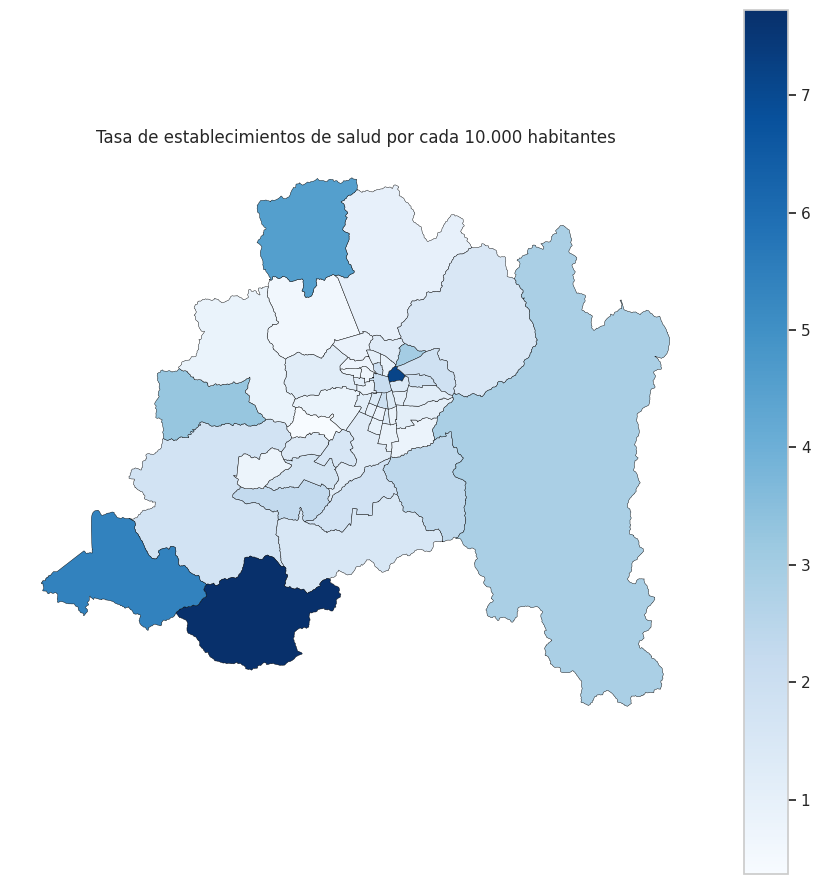

In [10]:
# Celda 13: choropleth de tasa de salud

fig, ax = plt.subplots(figsize=(9, 9))

col_tasa = "tasa_establecimientos_salud_x10k"

comunas_indicadores.plot(
    column=col_tasa,
    ax=ax,
    legend=True,
    cmap="Blues",
    edgecolor="black",
    linewidth=0.3,
)

ax.set_title("Tasa de establecimientos de salud por cada 10.000 habitantes", fontsize=12)
ax.set_axis_off()

plt.tight_layout()
save_figure(fig, "choropleth_tasa_salud")
plt.show()


💾 Figura guardada en: /home/jovyan/outputs/figures/mapa_tasa_y_puntos_salud.png


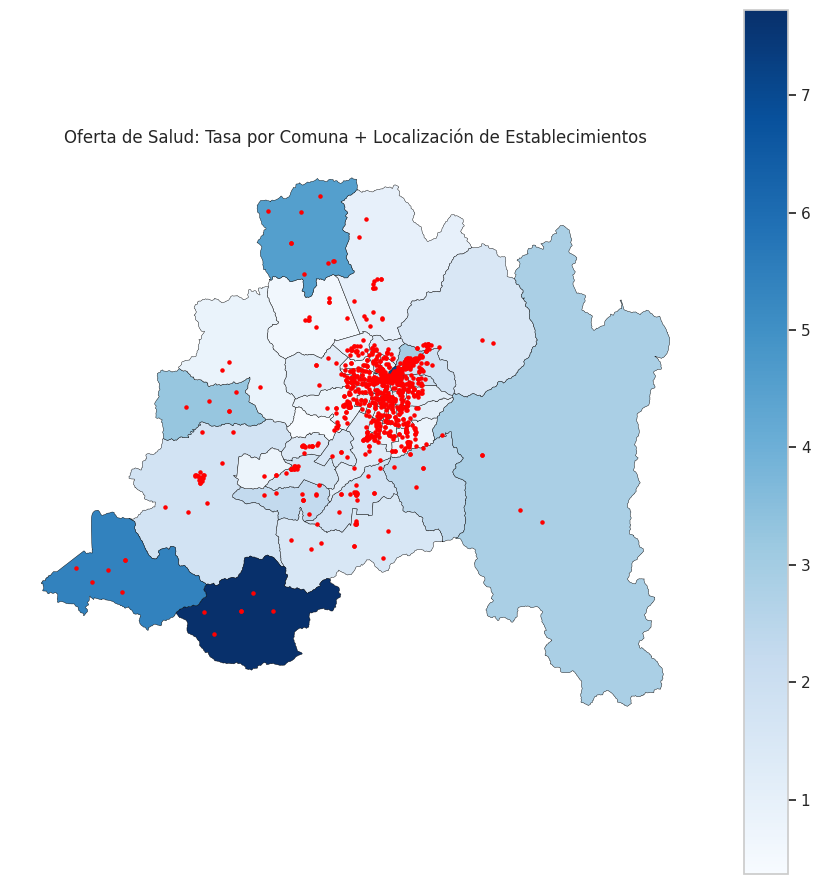

In [11]:
# Celda 14: mapa con tasa de salud y puntos de establecimientos

salud = gpd.read_file(RUTA_GPKG, layer="establecimientos_salud").to_crs(comunas_indicadores.crs)

fig, ax = plt.subplots(figsize=(9, 9))

comunas_indicadores.plot(
    column="tasa_establecimientos_salud_x10k",
    ax=ax,
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
)

salud.plot(ax=ax, markersize=5, color="red")

ax.set_title("Oferta de Salud: Tasa por Comuna + Localización de Establecimientos", fontsize=12)
ax.set_axis_off()

plt.tight_layout()
save_figure(fig, "mapa_tasa_y_puntos_salud")
plt.show()


💾 Figura guardada en: /home/jovyan/outputs/figures/mapa_tasa_y_puntos_supermercados.png


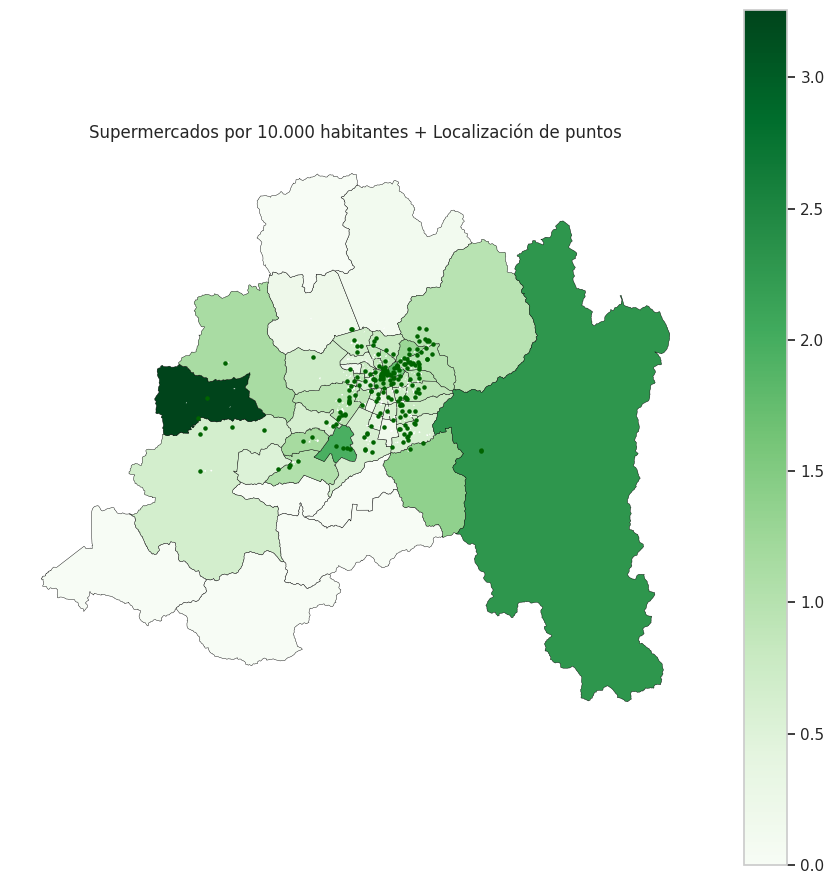

In [12]:
# Celda 15: supermercados (tasa y puntos)

supermercados = gpd.read_file(RUTA_GPKG, layer="osm_supermercados").to_crs(comunas_indicadores.crs)

fig, ax = plt.subplots(figsize=(9, 9))

comunas_indicadores.plot(
    column="tasa_osm_supermercados_x10k",
    ax=ax,
    cmap="Greens",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
)

supermercados.plot(ax=ax, markersize=5, color="darkgreen")

ax.set_title("Supermercados por 10.000 habitantes + Localización de puntos", fontsize=12)
ax.set_axis_off()

plt.tight_layout()
save_figure(fig, "mapa_tasa_y_puntos_supermercados")
plt.show()


In [14]:
# Guardar indicadores de oferta de servicios por comuna
indicadores_path = PROCESSED_DATA / "indicadores_servicios.csv"
indicadores.to_csv(indicadores_path, index=False)
print(f"Indicadores guardados en: {indicadores_path}")


Indicadores guardados en: /home/jovyan/data/processed/indicadores_servicios.csv
